AdaGrad累积梯度 → RMSProp加遗忘机制 → Adadelta加更新量EMA，去掉学习率

In [1]:
%matplotlib inline
import math
import torch
from d2l import torch as d2l

## AdaGrad 算法

算法的核心思想是不同参数根据历史梯度的大小自动调整学习率，实现

- 被频繁更新的参数 → 学习率逐变小

- 很少被更新的参数 → 保持较大的学习率

设参数为$\theta_t$，当前梯度为$g_t$， AdaGrad算法为每个参数维护一个历史梯度平方和

$$
G_t = \sum_{\tau=1}^{t} g^2_{\tau}
$$

更新规则为

$$
\theta_{t+1} = \theta_{t} - \dfrac{\eta}{\sqrt{G_t + \epsilon}} \cdot g_t
$$

随着不断更新，$G_t$逐渐增大，学习率逐渐变小。

- 对于频繁出现的特征，梯度经常非零，$G_t$增长快，学习率下降；

- 对于很少出现的稀疏特征，梯度大多数时间为$0$，学习率保持很大；

*注：表达式中的$\epsilon$用于防止除零。*

---

以二次凸问题为例，

$$
f(\mathbf{x}) = 0.1 x_1^2 + 2x_2^2
$$

epoch 20, x1: -2.382563, x2: -0.158591


c:\Software\Anaconda\envs\d2l\lib\site-packages\torch\functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:4324.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


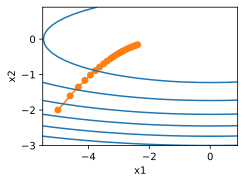

In [2]:
def adagrad_2d(x1, x2, s1, s2):
    eps = 1e-6
    g1, g2 = 0.2 * x1, 4 * x2
    s1 += g1 ** 2
    s2 += g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2

    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta = 0.4
d2l.show_trace_2d(f_2d, d2l.train_2d(adagrad_2d))

epoch 20, x1: -0.396477, x2: -0.000023


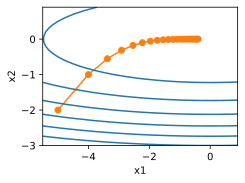

In [3]:
eta = 1
d2l.show_trace_2d(f_2d, d2l.train_2d(adagrad_2d))

In [4]:
def init_adagrad_states(feature_dim):
    s_w = torch.zeros((feature_dim, 1))
    s_b = torch.zeros(1)
    return (s_w, s_b)

def adagrad(params, states, hyperparams):
    eps = 1e-6
    for p, s in zip(params, states):
        with torch.no_grad():
            s[:] += torch.square(p.grad)
            p[:] -= hyperparams['lr'] * p.grad / torch.sqrt(s + eps)
        p.grad.data.zero_()

In [5]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
next(iter(data_iter)), feature_dim

([tensor([[ 1.0832, -1.1464, -0.3737, -0.7234, -0.7361],
          [-0.2813, -0.6393,  1.7993, -0.7234, -0.4703],
          [ 1.0832, -0.4703,  0.9844, -1.2308, -0.4602],
          [-0.5192,  0.2734, -0.9170,  1.3129, -0.4446],
          [ 1.0832, -0.2336,  0.1695,  0.2980, -0.5178],
          [-0.8524,  1.7947, -1.1886, -0.7234,  0.4626],
          [-0.5986, -0.2336,  0.1695, -1.2308, -0.4477],
          [ 0.0836,  0.0875,  0.9844, -0.7234,  0.0919],
          [-0.7160, -0.6393,  1.7993, -1.2308, -0.4446],
          [-0.5192,  1.4566, -0.9170, -1.2308,  1.3575]]),
  tensor([ 0.1153, -0.6241, -1.7599,  1.0513, -1.0946, -1.5649,  0.4937, -1.5264,
           0.5600, -0.2292])],
 5)

loss: 0.242, 0.007 sec/epoch


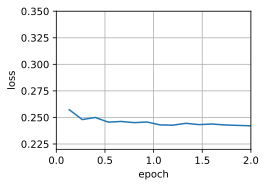

In [6]:
d2l.train_ch11(adagrad, init_adagrad_states(feature_dim),
               {'lr': 0.1}, data_iter, feature_dim);

loss: 0.242, 0.007 sec/epoch


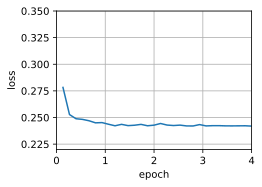

In [7]:
trainer = torch.optim.Adagrad
d2l.train_concise_ch11(trainer, {'lr': 0.1}, data_iter)

## RMSProp算法

AdaGrad算法的$G_t$会持续累加梯度，导致学习率越来越小，趋近于$0$，模型会提前终止学习。对于深度学习中的非凸复杂任务，需要模型在不同区域重新加速，而AdaGrad学习率只会下降，不会升高。

RMSProp是针对AdaGrad算法的改进，**不让梯度平方无线累积，而是做指数加权移动平均**。

该算法维护一个指数衰减的梯度平方

$$
\begin{aligned}
v_t &= \gamma v_{t-1} + (1 - \gamma)g^2_t\\
&= (1-\gamma)g_t^2 + (1-\gamma)\gamma g_{t-1}^2 + (1-\gamma)\gamma^2 g_{t-2}^2 + \cdots
\end{aligned}
$$

> 指数加权移动平均(EMA)：对过去的值加权平均，越新的数据权重越大，权重按指数衰减

更新

$$
\theta_{t+1} = \theta_{t} - \dfrac{\eta}{\sqrt{v_t + \epsilon}} \cdot g_t
$$



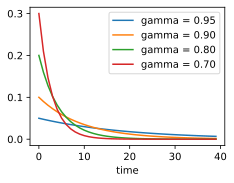

In [8]:
d2l.set_figsize()
gammas = [0.95, 0.9, 0.8, 0.7]
for gamma in gammas:
    x = torch.arange(40).detach().numpy()
    d2l.plt.plot(x, (1-gamma) * gamma ** x, label=f'gamma = {gamma:.2f}')
d2l.plt.xlabel('time')
d2l.plt.legend()

从仿真结果可以看出，$\gamma$越大，衰减越慢，**长期记忆**越多。

epoch 20, x1: -0.000343, x2: 0.000000


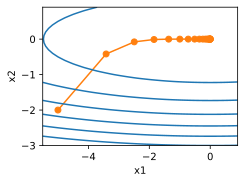

In [9]:
def rmsprop_2d(x1, x2, s1, s2):
    g1, g2, eps = 0.2 * x1, 4 * x2, 1e-6
    s1 = gamma * s1 + (1 - gamma) * g1 ** 2
    s2 = gamma * s2 + (1 - gamma) * g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta, gamma = 0.5, 0.9
d2l.show_trace_2d(f_2d, d2l.train_2d(rmsprop_2d))

In [10]:
def init_rmsprop_states(feature_dim):
    s_w = torch.zeros((feature_dim, 1))
    s_b = torch.zeros(1)
    return (s_w, s_b)

def rmsprop(params, states, hyperparams):
    gamma, eps = hyperparams['gamma'], 1e-6
    for p, s in zip(params, states):
        with torch.no_grad():
            s[:] = gamma * s + (1 - gamma) * torch.square(p.grad)
            p[:] -= hyperparams['lr'] * p.grad / torch.sqrt(s + eps)
        p.grad.data.zero_()

loss: 0.243, 0.010 sec/epoch


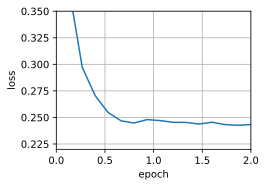

In [11]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(rmsprop, init_rmsprop_states(feature_dim),
               {'lr': 0.01, 'gamma': 0.9}, data_iter, feature_dim);

loss: 0.244, 0.015 sec/epoch


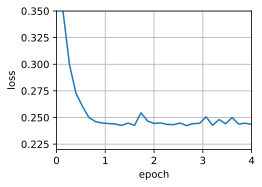

In [12]:
trainer = torch.optim.RMSprop
d2l.train_concise_ch11(trainer, {'lr': 0.01, 'alpha': 0.9},
                       data_iter)

## Adadelta

RMSProp中还残留手动学习率$\eta$，在Adadelta算法中，使用两个EMA摆脱手动学习率的问题，

梯度平方的EMA

$$
s_t = \gamma s_{t-1} + (1-\gamma)g_t^2
$$

然后私用缩放后的梯度执行更新，

$$
x_t = x_{t-1} - g_t'
$$

Adadelta算法引入第二个状态变量记录参数更新量平方的EMA

$$
\Delta x_t = \gamma \Delta x_{t-1} + (1-\gamma) g_t'^2
$$

使用上一轮更新量平方来缩放当前梯度，更新规则为

$$
g_t' = -\dfrac{\sqrt{\Delta x_{t-1} + \epsilon}}{\sqrt{s_t + \epsilon}} \odot g_t
$$

In [13]:
def init_adadelta_states(feature_dim):
    s_w, s_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    delta_w, delta_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    return ((s_w, delta_w), (s_b, delta_b))

def adadelta(params, states, hyperparams):
    rho, eps = hyperparams['rho'], 1e-5
    for p, (s, delta) in zip(params, states):
        with torch.no_grad():
            # In-placeupdatesvia[:]
            s[:] = rho * s + (1 - rho) * torch.square(p.grad)
            g = (torch.sqrt(delta + eps) / torch.sqrt(s + eps)) * p.grad
            p[:] -= g
            delta[:] = rho * delta + (1 - rho) * g * g
        p.grad.data.zero_()

loss: 0.244, 0.019 sec/epoch


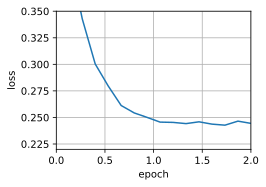

In [14]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(adadelta, init_adadelta_states(feature_dim),
               {'rho': 0.9}, data_iter, feature_dim);

loss: 0.243, 0.018 sec/epoch


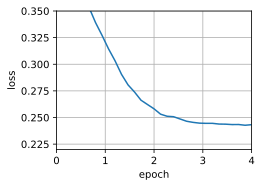

In [15]:
trainer = torch.optim.Adadelta
d2l.train_concise_ch11(trainer, {'rho': 0.9}, data_iter)

## Adam算法

In [16]:
def init_adam_states(feature_dim):
    v_w, v_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    s_w, s_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    return ((v_w, s_w), (v_b, s_b))

def adam(params, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-6
    for p, (v, s) in zip(params, states):
        with torch.no_grad():
            v[:] = beta1 * v + (1 - beta1) * p.grad
            s[:] = beta2 * s + (1 - beta2) * torch.square(p.grad)
            v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
            s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
            p[:] -= hyperparams['lr'] * v_bias_corr / (torch.sqrt(s_bias_corr)
                                                       + eps)
        p.grad.data.zero_()
    hyperparams['t'] += 1

loss: 0.245, 0.017 sec/epoch


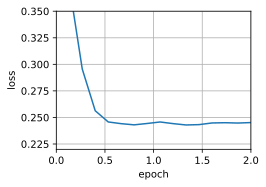

In [17]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(adam, init_adam_states(feature_dim),
               {'lr': 0.01, 't': 1}, data_iter, feature_dim);

loss: 0.242, 0.017 sec/epoch


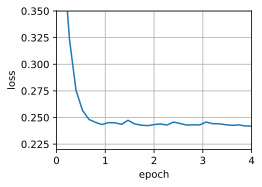

In [18]:
trainer = torch.optim.Adam
d2l.train_concise_ch11(trainer, {'lr': 0.01}, data_iter)

loss: 0.247, 0.018 sec/epoch


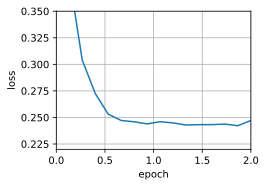

In [19]:
def yogi(params, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-3
    for p, (v, s) in zip(params, states):
        with torch.no_grad():
            v[:] = beta1 * v + (1 - beta1) * p.grad
            s[:] = s + (1 - beta2) * torch.sign(
                torch.square(p.grad) - s) * torch.square(p.grad)
            v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
            s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
            p[:] -= hyperparams['lr'] * v_bias_corr / (torch.sqrt(s_bias_corr)
                                                       + eps)
        p.grad.data.zero_()
    hyperparams['t'] += 1

data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(yogi, init_adam_states(feature_dim),
               {'lr': 0.01, 't': 1}, data_iter, feature_dim);